# Car Autoencoder (CIFAR-10)

In [147]:
# import
from keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, load_model 
from keras.datasets import mnist, cifar10
import random as random
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# constants
IMG_SIZE = 32
NUM_CHANNELS = 3

## Training Data

#### Load CIFAR-10 

In [356]:
def get_CIFAR10():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Pixel values go from 0 to 255. 
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    
    return (x_train, y_train, x_test, y_test)

In [ ]:
full_x_train = x_train
full_y_train = y_train

full_x_test = x_test
full_y_test = y_test

# Images are 32x32x3 -- flatten them. 
img_dims = x_train.shape[1:]

print(x_train.shape)
print(x_test.shape)

#### Select 'car' images

In [357]:
def select_car_images():
    (x_train, y_train, x_test, y_test) = get_CIFAR10()

    # we only want 'car' images (labeled 1): filter the rest out
    not_cars = np.where(y_train!=1)[0]
    x_train = np.delete(x_train, not_cars, axis=0)
    y_train = np.delete(y_train, not_cars, axis=0)

    not_cars = np.where(y_test!=1)[0]
    x_test = np.delete(x_test, not_cars, axis=0)
    y_test = np.delete(y_test, not_cars, axis=0)
    
    return (x_train, y_train, x_test, y_test)

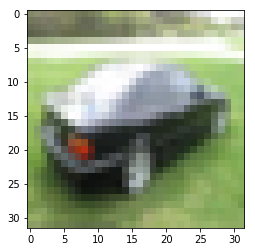

In [361]:
# verify
(x_train, _, _, _) = select_car_images()
r = random.randint(0, x_train.shape[0]-1)
plt.imshow(x_train[r].reshape(IMG_SIZE, IMG_SIZE, 3))
plt.show()

#### Augment training data with rotations and flips

In [27]:
# Run this after creating a clean augmented_images/ directory. 

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=[0.5, 1],
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True)

datagen.fit(x_train)

i = 0

for batch in datagen.flow(x_train, 
                          batch_size=256, 
                          save_to_dir='/Users/vwr/augmented_images/',
                          save_prefix='car',
                          save_format='jpeg'):
    i += 1
    if i > 20:
        break # otherwise the generator would loop indefinitely

In [63]:
from image_utils import get_images_train

augmented_car_train = get_images_train('augmented_car_train.npy', 
                             train_dir = '/Users/vwr/augmented_images/',
                             refresh=True)

Fetching and processing images from directory:  /Users/vwr/augmented_images/
Saved training data into:  augmented_car_train.npy
Shape of training data: (5256, 32, 32, 3)


#### Create final training data

In [64]:
car_train = np.concatenate((x_train, augmented_car_train), axis = 0)
print(car_train.shape)

(10256, 32, 32, 3)


## Convolutional encoder + Dense decoder

In [66]:
from keras.layers import Reshape
from keras.optimizers import Adam

input_img = Input(shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))

# build the network
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)
x = MaxPooling2D((2, 2,), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# decoder
decoded = Flatten()(encoded)
decoded = Dense(3072, activation="sigmoid")(decoded)
decoded = Reshape((IMG_SIZE, IMG_SIZE, NUM_CHANNELS))(decoded)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(lr=0.0012), loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 4, 4, 128)         0         
__________

In [68]:

# train
autoencoder.fit(car_train, car_train,
                epochs=60,
                batch_size=256,
                shuffle=True,
                )

Epoch 1/60
10256/10256 [==============================] - 22s - loss: 0.5320    
Epoch 2/60
10256/10256 [==============================] - 24s - loss: 0.5318    
Epoch 3/60
10256/10256 [==============================] - 24s - loss: 0.5323    
Epoch 4/60
10256/10256 [==============================] - 23s - loss: 0.5318    
Epoch 5/60
10256/10256 [==============================] - 24s - loss: 0.5317    
Epoch 6/60
10256/10256 [==============================] - 24s - loss: 0.5316    
Epoch 7/60
10256/10256 [==============================] - 23s - loss: 0.5313    
Epoch 8/60
10256/10256 [==============================] - 23s - loss: 0.5314    
Epoch 9/60
10256/10256 [==============================] - 23s - loss: 0.5314    
Epoch 10/60
10256/10256 [==============================] - 24s - loss: 0.5312    
Epoch 11/60
10256/10256 [==============================] - 25s - loss: 0.5310    
Epoch 12/60
10256/10256 [==============================] - 25s - loss: 0.5311    
Epoch 13/60
10256/10256 [

#### (Optional) Save model

In [71]:
autoencoder.save("0.52392_car_convolutional_autoencoder")


### How well does it generalize to the test set?

In [69]:
decoded_imgs = autoencoder.predict(x_test)

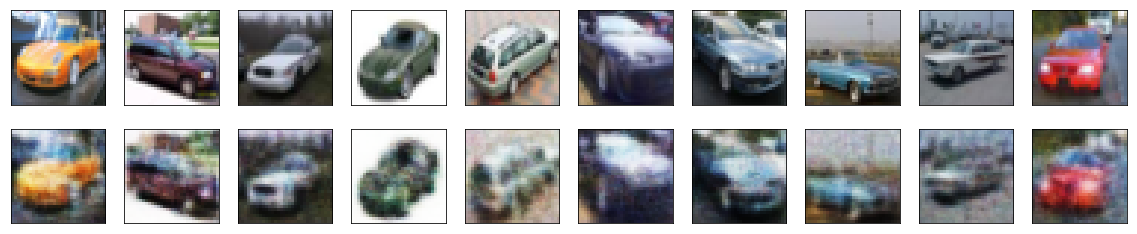

In [76]:
n = 10  # the number of panels to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # 50
    index = i + 140
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[index].reshape(IMG_SIZE, IMG_SIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[index].reshape(IMG_SIZE, IMG_SIZE, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Visualizing the layers/filters

### Are we actually learning car features? Using our autoencoder to classify cars (transfer learning)

#### Training data

In [398]:
(x_train, y_train, x_test, y_test) = get_CIFAR10()

"""
We want a 50/50 split of cars and "not_cars" (birds, dogs, trucks, etc.)
Currently training set has a 1:9 split of cars and not_cars (50,000 examples: 5,000 cars and 45,000 not-cars). 

"""

# get indices of not_cars - should be 45,000 of them
indices_not_cars = np.where(y_train!=1)[0] # cars labeled with '1'

# delete 90% of the not_car rows so it's roughly equal: 5,000 cars and 4,500 not-cars. 
rows_to_delete = np.delete(indices_not_cars, np.s_[0:4500], axis=0)
x_train = np.delete(x_train, rows_to_delete, axis=0)
y_train = np.delete(y_train, rows_to_delete, axis=0)

# save the actual labels (0-9 for each class, like 'airplane', 'car', 'bird', etc.)
actual_labels = np.copy(y_train)
# set the labels of not_cars to 0
indices_not_cars = np.where(y_train!=1)[0] 
y_train[indices_not_cars] = 0

np.testing.assert_equal(x_train.shape[0], 9500)
np.testing.assert_equal(np.sum(y_train), 5000)


#### Load autoencoder, freeze its layers, and add a classifier layer to it

In [399]:
input_img = Input(shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))
model_base = load_model("0.52392_car_convolutional_autoencoder")

# Freeze layers of the base model (our trained encoder)
for layer in model_base.layers:
    layer.trainable = False
x = model_base.get_layer('conv3').output
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(encoded)
x = Dense(1, activation='sigmoid')(x)

classifier = Model(model_base.input, x)
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 4, 4, 128)         0         
__________

In [748]:

# train
classifier.fit(x_train, y_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                )

Epoch 1/50
9500/9500 [==============================] - 5s - loss: 0.1859 - acc: 0.9280     
Epoch 2/50
9500/9500 [==============================] - 5s - loss: 0.1869 - acc: 0.9280     
Epoch 3/50
9500/9500 [==============================] - 5s - loss: 0.1836 - acc: 0.9284     
Epoch 4/50
9500/9500 [==============================] - 5s - loss: 0.1845 - acc: 0.9315     
Epoch 5/50
9500/9500 [==============================] - 5s - loss: 0.1813 - acc: 0.9312     
Epoch 6/50
9500/9500 [==============================] - 6s - loss: 0.1819 - acc: 0.9311     
Epoch 7/50
9500/9500 [==============================] - 5s - loss: 0.1810 - acc: 0.9315     
Epoch 8/50
9500/9500 [==============================] - 5s - loss: 0.1809 - acc: 0.9328     
Epoch 9/50
9500/9500 [==============================] - 5s - loss: 0.1857 - acc: 0.9251     
Epoch 10/50
9500/9500 [==============================] - 5s - loss: 0.1810 - acc: 0.9306     
Epoch 11/50
9500/9500 [==============================] - 6s - loss: 0

In [749]:
predictions = classifier.predict(x_test)
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1
print(predictions.shape)

(10000, 1)


[ 1.]


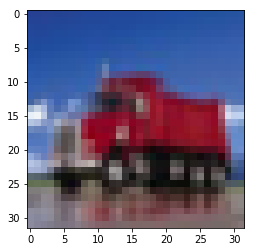

In [750]:
ind = random.randint(0, 9500)
print(predictions[ind])
plt.imshow(x_test[ind])
plt.show()

#### What does our classifier get confused by? 

In [751]:
# i have predictions: for every row, I have 0 or 1 the model's prediction on whether it's a car or not
# I have labels for every row: 0-9 based on the type of object it is
# I want to combine them so it's like
# model  label
# 1 .      4
# 1 .      1
# 1 .      6
# 0 .      1

# I want to construct a table
# so 4 has 5 1's, label 6 has 20 1's
# I want to filter it
# for every row, 
# if model's prediction is 1
# table[category[label]] += 1

# I have a dictionary from label (0 to 9) to its object (car, etc.) 

category_of = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
table = {
    'plane': 0,
    'car': 0, 
    'bird': 0, 
    'cat': 0,
    'deer': 0,
    'dog': 0,
    'frog': 0,
    'horse': 0,
    'ship': 0,
    'truck': 0
}

total_counts = {
    'plane': 0,
    'car': 0, 
    'bird': 0, 
    'cat': 0,
    'deer': 0,
    'dog': 0,
    'frog': 0,
    'horse': 0,
    'ship': 0,
    'truck': 0
}

for i in range(predictions.shape[0]):
    c = category_of[y_test[i][0]]
    total_counts[c] += 1
    if predictions[i] == 1:
        table[c] += 1
        
print(table)
print(total_counts)


{'plane': 172, 'car': 876, 'bird': 58, 'cat': 88, 'deer': 56, 'dog': 62, 'frog': 103, 'horse': 95, 'ship': 279, 'truck': 522}
{'plane': 1000, 'car': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


### How much of each category does our classifier think is a car?

#### 'car': 872/1000  
#### 'truck': 514/1000  
#### 'ship': 267/1000  
#### 'plane': 163/1000  
#### 'frog': 94/1000  
#### 'horse': 83/1000  
#### 'cat': 80/1000  
#### 'bird': 52/1000  
#### 'dog': 50/1000  